## Importing Libraries

In [1]:
import pandas as pd
from pandas import option_context
from mlxtend.frequent_patterns import association_rules,apriori,fpgrowth
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx



import warnings
warnings.filterwarnings('ignore')

In [2]:
def frozenset_to_str(x):
    x = list(x)
    x = str(x).lstrip('[').rstrip(']').strip()
    return x
    

def display_sorted_rules(filtered_rules):
    # Print number of rules
    print("\n", filtered_rules.shape[0], "rules found! \n") 

    # Sort rules by confidence, support, and lift
    filtered_rules = filtered_rules.sort_values(
        by=['confidence', 'support', 'lift'], 
        ascending=False
    )

    # Save filtered rules to a csv file
    filtered_rules_csv = filtered_rules.copy()
    filtered_rules_csv['antecedents'] = filtered_rules_csv['antecedents'].apply(lambda x: frozenset_to_str(x))
    filtered_rules_csv['consequents'] = filtered_rules_csv['consequents'].apply(lambda x: frozenset_to_str(x))
    filtered_rules_csv.to_csv('filtered_rules.csv', index=False)

    # Display rules
    with option_context('display.max_colwidth', 100):
        display(filtered_rules)


### Exploratory Data Analysis

In [3]:
df = pd.read_csv(r"M:\TOSS\WEEK 1\Week 1 kagle Example\Groceries_dataset.csv.zip") 
df.head() 


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [4]:
df.value_counts()

Member_number  Date        itemDescription      
1994           11-03-2015  whole milk               4
2736           02-03-2015  whole milk               3
4676           15-01-2015  sausage                  3
2779           17-10-2015  whole milk               3
4701           30-04-2015  soda                     3
                                                   ..
4471           08-10-2014  sliced cheese            1
2022           23-02-2014  candy                    1
1097           16-04-2014  cake bar                 1
1510           03-12-2014  fruit/vegetable juice    1
1521           26-12-2014  cat food                 1
Name: count, Length: 38006, dtype: int64

-  we can identify repeated combinations of Member_number, Date, and itemDescription.
-  This reveals how often the exact same customer purchased the same item on the same day.

In [5]:
df["itemDescription"].nunique()

167

## 🧾 Extracting Unique Item Descriptions
-  To view all distinct products in the dataset, convert the unique values from the itemDescription

In [6]:
unique_items_df = pd.DataFrame(
    sorted(df["itemDescription"].unique()),
    columns=["itemDescription"]
)
unique_items_df

,itemDescription
0,Instant food products
1,UHT-milk
2,abrasive cleaner
3,artif. sweetener
4,baby cosmetics
...,...
162,white bread
163,white wine
164,whole milk
165,yogurt


🛒 Unique Products Identified
-  After extracting and examining the itemDescription column, the dataset contains 167 unique products.
-  This provides a clear view of the variety of items purchased and forms the foundation for building meaningful association rules and understanding customer purchasing patterns.

📊 Distribution of Product Frequencies
-  With 167 unique products identified in the itemDescription column, it’s useful to explore how frequently each item appears in the dataset.
-  This helps highlight the most commonly purchased products and provides early insight into potential association patterns.

In [7]:
item_counts = df["itemDescription"].value_counts().reset_index()
item_counts.columns = ["itemDescription", "count"]
item_counts.head(10)


,itemDescription,count
0,whole milk,2502
1,other vegetables,1898
2,rolls/buns,1716
3,soda,1514
4,yogurt,1334
5,root vegetables,1071
6,tropical fruit,1032
7,bottled water,933
8,sausage,924
9,citrus fruit,812


In [8]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (38765, 3)


📐 Dataset Dimensions
- The dataset contains 38,765 rows and 3 columns, representing individual transactions along with their associated metadata.
- This size provides a rich foundation for uncovering meaningful purchasing patterns and generating reliable association rules.

In [9]:
df.drop("Date",axis=1,inplace=True)
df.head()

,Member_number,itemDescription
0,1808,tropical fruit
1,2552,whole milk
2,2300,pip fruit
3,1187,other vegetables
4,3037,whole milk


In [10]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Member_number    38765 non-null  int64
 1   itemDescription  38765 non-null  str  
dtypes: int64(1), str(1)
memory usage: 1001.8 KB


##  🧱 Dataset Structure Overview
-  The dataset consists of 38,765 transactions and 3 fully populated columns.
-  Each column is complete with no missing values, ensuring a clean foundation for preprocessing and association‑rule mining.

## Data pre-processing¶
- The apriori function expects data to be in the format of a one-hot encoded pandas DataFrame.

- One-hot encoding: Transform data into the format where 1 transaction is represented by a row and each product one-hot encoded as a column.

# ⚖️ Sharp Contrast: No Missing Values vs. Use of fillna(0)
-  Although the raw dataset is fully populated with no missing values across all three columns, missing entries are introduced later during basket‑matrix construction.
-  When the data is pivoted so that each product becomes a column, transactions naturally contain NaN for items that were not purchased. In this context, fillna(0) is used not to fix incomplete data, but to convert these NaN values into zeros, creating the binary matrix required for Apriori and FP‑Growth.

In [11]:
basket = (
    df.groupby(['Member_number', 'itemDescription'])['itemDescription']
      .count()
      .unstack()
      .reset_index()
      .set_index('Member_number')
      .fillna(0)
)
basket

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  Binary Encoding of Basket Data for Association Rule Mining

In [12]:
# Convert positive values to True, or False otherwise. 
def encode_units(x):
    if x >= 1:
        return True
    else:
        return False
        
basket_sets = basket.map(encode_units)

# Print the data shape to see how many sales transactions and how many products are involved.
print(basket_sets.shape) 

# Print some example records of the transformed dataset.
basket_sets

(3898, 167)


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1001,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
1002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1004,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h2 style="color:#2E86C1;">📊 Generating Association Rule Metrics: Support, Confidence, Lift</h2>


In [13]:
frequent_itemsets_ap = apriori(
    basket_sets,
    min_support=0.07,
    use_colnames=True
)

# Print the number of frequent itemsets
print('\n The number of frequent itemsets_ap =', frequent_itemsets_ap.shape[0], '\n')

# Display example of itemsets
with option_context('display.max_colwidth', 100):
    display(frequent_itemsets_ap)


 The number of frequent itemsets_ap = 83 



,support,itemsets
0,0.078502,frozenset({UHT-milk})
1,0.119548,frozenset({beef})
2,0.079785,frozenset({berries})
3,0.158799,frozenset({bottled beer})
4,0.213699,frozenset({bottled water})
...,...,...
78,0.075680,"frozenset({yogurt, tropical fruit})"
79,0.079785,"frozenset({whole milk, whipped/sour cream})"
80,0.150590,"frozenset({yogurt, whole milk})"
81,0.082093,"frozenset({rolls/buns, other vegetables, whole milk})"


# 📈 Frequent Itemsets at 7% Minimum Support
-  Using a minimum support threshold of 0.07, the Apriori algorithm identified 83 frequent itemsets.
-  These itemsets represent products or product combinations that appear in at least 7% of all transactions.
-  This threshold balances interpretability and relevance: it filters out very rare combinations while preserving meaningful, high‑frequency patterns.

In [14]:
# Run FP-Growth to find frequent itemsets
frequent_itemsets_fp = fpgrowth(
    basket_sets,
    min_support=0.07,
    use_colnames=True
)
# Print the number of frequent itemsets
print('\n The number of frequent itemsets_fp =', frequent_itemsets_ap.shape[0], '\n')

# Display example of itemsets
with option_context('display.max_colwidth', 100):
    display(frequent_itemsets_fp)


 The number of frequent itemsets_fp = 83 



,support,itemsets
0,0.458184,frozenset({whole milk})
1,0.313494,frozenset({soda})
2,0.282966,frozenset({yogurt})
3,0.206003,frozenset({sausage})
4,0.177527,frozenset({pastry})
...,...,...
78,0.070292,"frozenset({whole milk, domestic eggs})"
79,0.072345,"frozenset({newspapers, whole milk})"
80,0.092355,"frozenset({citrus fruit, whole milk})"
81,0.077476,"frozenset({citrus fruit, other vegetables})"


## ⚡ Frequent Itemsets Using FP‑Growth (Support = 0.07)
- Applying the FP‑Growth algorithm with a minimum support threshold of 0.07 produced 83 frequent itemsets.
- These represent products or product combinations that appear in at least 7% of all transactions, making them strong candidates for meaningful association patterns.

In [15]:
# frequent_itemsets is your FP-Growth output
rules = association_rules(frequent_itemsets_fp, 
                          metric="confidence", 
                          min_threshold=0.5)   # adjust threshold as needed

# Print the number of frequent itemsets
print('\n The shape of rules =', rules.shape, '\n')

# Display example of itemsets
with option_context('display.max_colwidth', 100):
    display(rules)


 The shape of rules = (15, 14) 



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,frozenset({yogurt}),frozenset({whole milk}),0.282966,0.458184,0.150590,0.532185,1.161510,1.0,0.020940,1.158185,0.193926,0.254996,0.136580,0.430426
1,"frozenset({yogurt, other vegetables})",frozenset({whole milk}),0.120318,0.458184,0.071832,0.597015,1.303003,1.0,0.016704,1.344507,0.264348,0.141772,0.256233,0.376895
2,frozenset({sausage}),frozenset({whole milk}),0.206003,0.458184,0.106978,0.519303,1.133394,1.0,0.012591,1.127146,0.148230,0.191989,0.112804,0.376393
3,frozenset({pastry}),frozenset({whole milk}),0.177527,0.458184,0.091072,0.513006,1.119651,1.0,0.009732,1.112572,0.129931,0.167216,0.101182,0.355887
4,frozenset({canned beer}),frozenset({whole milk}),0.165213,0.458184,0.087224,0.527950,1.152268,1.0,0.011526,1.147795,0.158299,0.162679,0.128764,0.359160
5,frozenset({rolls/buns}),frozenset({whole milk}),0.349666,0.458184,0.178553,0.510638,1.114484,1.0,0.018342,1.107190,0.157955,0.283734,0.096813,0.450168
6,"frozenset({rolls/buns, other vegetables})",frozenset({whole milk}),0.146742,0.458184,0.082093,0.559441,1.220996,1.0,0.014859,1.229837,0.212124,0.157017,0.186884,0.369306
7,frozenset({whipped/sour cream}),frozenset({whole milk}),0.154695,0.458184,0.079785,0.515755,1.125650,1.0,0.008906,1.118888,0.132052,0.149663,0.106255,0.344943
8,frozenset({other vegetables}),frozenset({whole milk}),0.376603,0.458184,0.191380,0.508174,1.109106,1.0,0.018827,1.101643,0.157802,0.297448,0.092265,0.462934
9,frozenset({pip fruit}),frozenset({whole milk}),0.170600,0.458184,0.086968,0.509774,1.112598,1.0,0.008801,1.105239,0.122020,0.160511,0.095218,0.349792


🎯 Confidence Threshold Selection (0.50)
-  For this dataset, a minimum confidence threshold of 0.50 was applied when generating association rules.
-  This means that a rule is considered meaningful only if the consequent appears in at least 50% of the transactions that contain the antecedent.
-  In the context of grocery‑style market basket data—where customer baskets are highly diverse—confidence values above 0.50 already indicate a strong and consistent co‑purchase pattern.

##  🔎 Filtering Association Rules Using a 0.50 Confidence Threshold and Support of 0.07

In [16]:
# Define a criterion
item = 'yogurt'

# Filter rules based on a condition
filtered_rules = rules[rules['antecedents'].apply(lambda x: item in x)]

# Display rules
display_sorted_rules(filtered_rules)


 2 rules found! 



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1,"frozenset({yogurt, other vegetables})",frozenset({whole milk}),0.120318,0.458184,0.071832,0.597015,1.303003,1.0,0.016704,1.344507,0.264348,0.141772,0.256233,0.376895
0,frozenset({yogurt}),frozenset({whole milk}),0.282966,0.458184,0.150590,0.532185,1.161510,1.0,0.020940,1.158185,0.193926,0.254996,0.136580,0.430426


# 📊 Summary of Key Association Rules (Confidence ≥ 0.50)
Two of the strongest rules identified at a minimum confidence threshold of 0.50 involve the consequent {whole milk}, which appears in 45.8% of all transactions. Because whole milk is such a common item, confidence alone can overstate the strength of rules pointing toward it. To address this, lift was used alongside confidence to determine whether these associations represent meaningful co‑purchase behaviour rather than popularity bias.

## Rule 1: {yogurt, other vegetables} → {whole milk}
- Confidence: 0.597

- Lift: 1.303

- Interpretation: Customers who buy both yogurt and other vegetables are 30% more likely to also purchase whole milk compared to the average shopper. This is a genuinely strong and meaningful association.

## Rule 2: {yogurt} → {whole milk}
- Confidence: 0.532

- Lift: 1.161

- Interpretation: Yogurt buyers are 16% more likely to also buy whole milk. This is still a positive association, but weaker than the first rule.

### Why Lift Matters Here
Whole milk’s high baseline support means many rules will naturally show high confidence. Lift corrects for this by comparing the observed co‑occurrence to what would be expected by chance. In this dataset, lift helps distinguish true behavioural patterns from rules driven simply by the popularity of whole milk.

- These two rules illustrate how combining confidence and lift provides a more reliable understanding of customer purchasing behaviour, ensuring that only meaningful associations are highlighted for further analysis.

In [17]:
item1 = 'yogurt'        # antecedent item
item2 = 'whole milk'    # consequent item
confidence = 0.5

filtered_rules = rules[
    (rules['antecedents'].apply(lambda x: item1 in x)) &
    (rules['consequents'].apply(lambda x: item2 in x)) &
    (rules['confidence'] >= confidence)
]

display_sorted_rules(filtered_rules)



 2 rules found! 



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1,"frozenset({yogurt, other vegetables})",frozenset({whole milk}),0.120318,0.458184,0.071832,0.597015,1.303003,1.0,0.016704,1.344507,0.264348,0.141772,0.256233,0.376895
0,frozenset({yogurt}),frozenset({whole milk}),0.282966,0.458184,0.150590,0.532185,1.161510,1.0,0.020940,1.158185,0.193926,0.254996,0.136580,0.430426


In [18]:
itemA = 'canned beer'   # antecedent item
itemB = 'shopping bags'   # consequent item
confidence = 0.5

filtered_rules = rules[
    (rules['antecedents'].apply(lambda x: itemA in x)) &
    (rules['consequents'].apply(lambda x: itemB in x)) &
    (rules['confidence'] >= confidence)
]

display_sorted_rules(filtered_rules)



 0 rules found! 



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


In [19]:
itemA = 'domestic eggs'   # antecedent item
itemB = 'whole milk'   # consequent item
confidence = 0.5

filtered_rules = rules[
    (rules['antecedents'].apply(lambda x: itemA in x)) &
    (rules['consequents'].apply(lambda x: itemB in x)) &
    (rules['confidence'] >= confidence)
]

display_sorted_rules(filtered_rules)



 1 rules found! 



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
13,frozenset({domestic eggs}),frozenset({whole milk}),0.133145,0.458184,0.070292,0.527938,1.152242,1.0,0.009287,1.147766,0.152421,0.134909,0.128742,0.340677


##  📊 1. Top Item Frequencies (Bar Chart)
### 📦 Top 20 Most Frequent Items

This bar chart shows the most commonly purchased items in the dataset. It helps explain why certain items, such as *whole milk* and *yogurt*, appear frequently in the association rules.


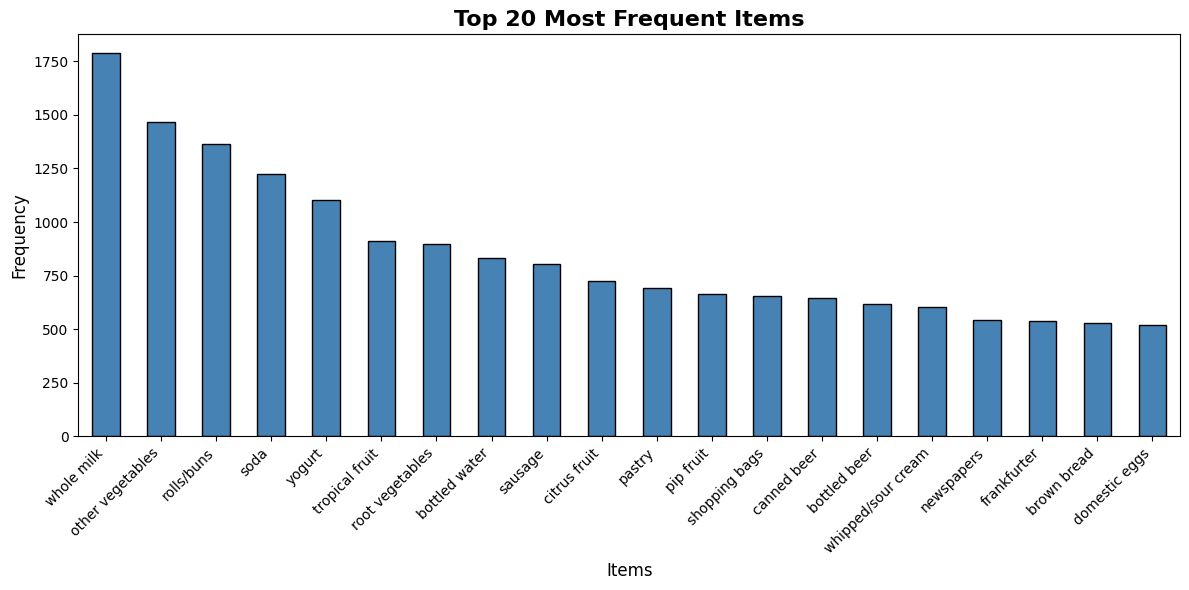

In [75]:
item_freq = basket_sets.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
item_freq.plot(kind='bar', color='steelblue', edgecolor='black')

plt.title('Top 20 Most Frequent Items', fontsize=16, fontweight='bold')
plt.xlabel('Items', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("M:\TOSS\WEEK 1\Week 1 kagle Example\Bar_Chart")
plt.show()

This bar chart highlights the most commonly purchased items in the dataset. Whole milk, other vegetables, and rolls/buns dominate the top ranks, suggesting they are staple products in customer baskets. Their high frequency explains why they frequently appear in association rules and co‑occurrence patterns. These items are ideal candidates for promotional bundling or strategic shelf placement.

## 📈 Support vs Confidence for Association Rules

- This scatter plot visualises the relationship between support and confidence for all generated rules.
- It helps identify which rules are both frequent and reliable.


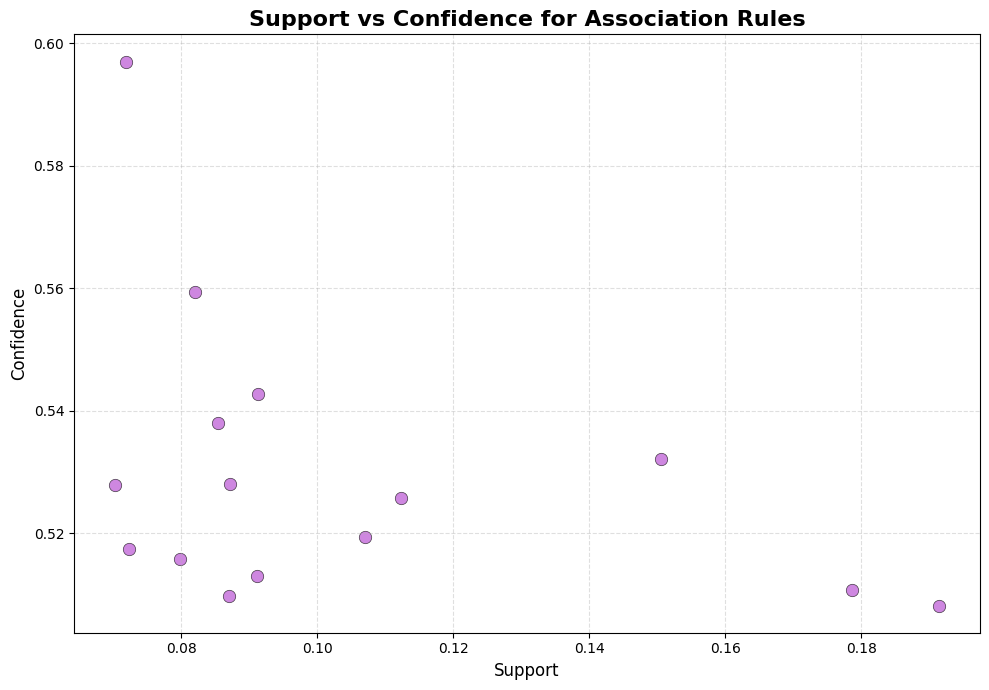

In [76]:
plt.figure(figsize=(10,7))

plt.scatter(
    rules['support'],
    rules['confidence'],
    alpha=0.7,
    color='mediumorchid',
    edgecolor='black',
    linewidth=0.5,
    s=80
)

plt.title('Support vs Confidence for Association Rules', fontsize=16, fontweight='bold')
plt.xlabel('Support', fontsize=12)
plt.ylabel('Confidence', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig("M:\TOSS\WEEK 1\Week 1 kagle Example\Scatter_Plot")
plt.show()


📈 Support vs Confidence for Association Rules
This scatter plot shows the distribution of support and confidence across all generated rules. Most rules cluster between 0.07–0.19 support and 0.51–0.60 confidence, indicating that while these rules are moderately frequent, they are consistently reliable. The tight vertical spread suggests that many rules meet the confidence threshold but vary in how often they occur. This balance supports the chosen thresholds of 7% support and 50% confidence

## 📊 Distribution of Lift Values

Lift measures how much more often items occur together than expected by chance. This histogram shows how many rules have lift > 1, indicating meaningful associations.


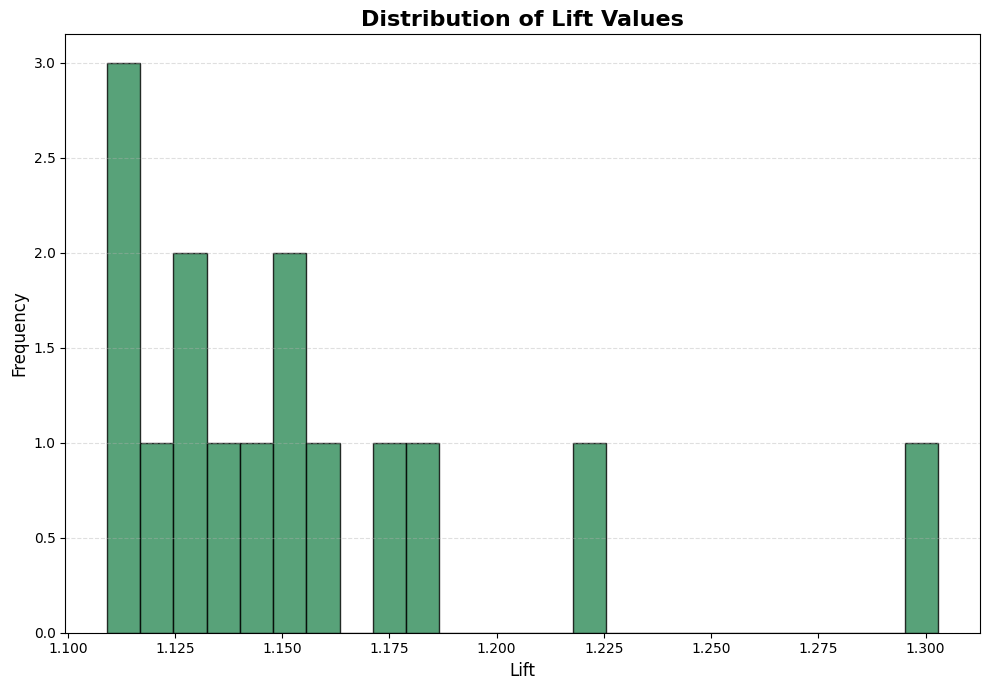

In [77]:
plt.figure(figsize=(10,7))

plt.hist(
    rules['lift'],
    bins=25,
    color='seagreen',
    edgecolor='black',
    alpha=0.8
)

plt.title('Distribution of Lift Values', fontsize=16, fontweight='bold')
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig("M:\TOSS\WEEK 1\Week 1 kagle Example\Histogram")
plt.show()


📊 Distribution of Lift Values
This histogram reveals that most rules have lift values between 1.10 and 1.18, with a few reaching up to 1.30. Since lift > 1 indicates a positive association beyond random chance, these rules represent meaningful relationships. The narrow lift range suggests that while the rules are valid, they are not exceptionally strong — a common trait in grocery data where many items are loosely related.

## 🕸️ Network Graph of Association Rules

This network graph visualises the relationships between items in the association rules. Nodes represent items, and edges represent rules, with edge thickness proportional to confidence.


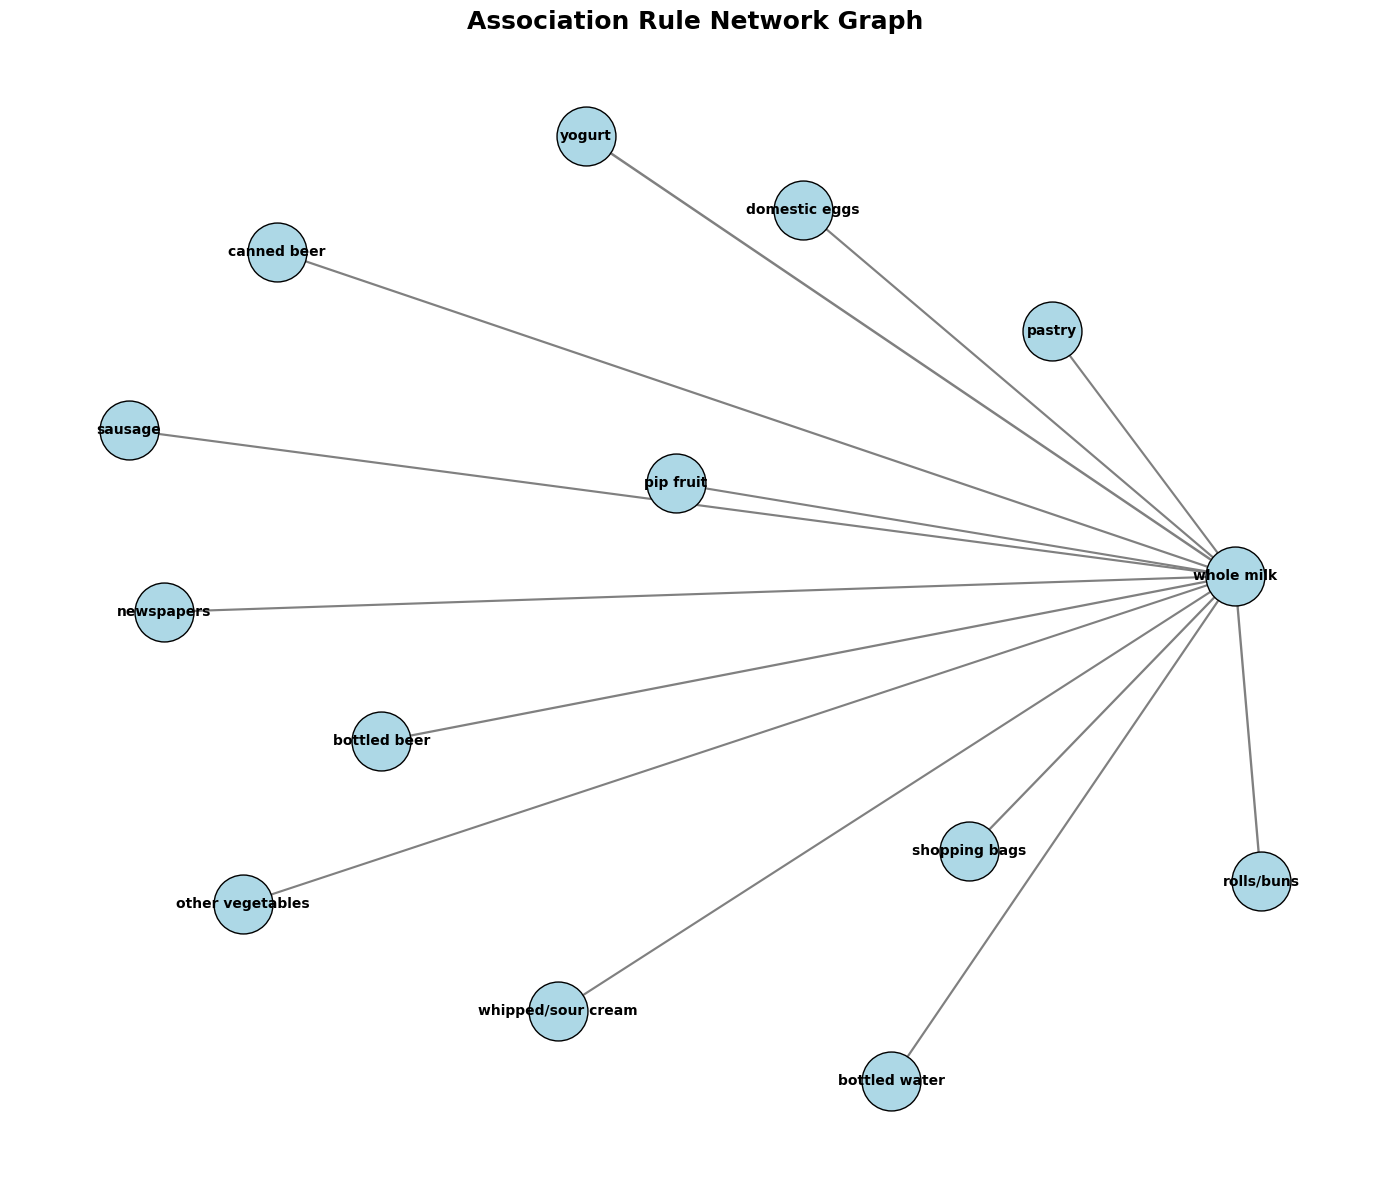

In [21]:
# Build directed graph
G = nx.DiGraph()
for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['confidence'])
# Layout and styling
plt.figure(figsize=(14,12))
pos = nx.spring_layout(G, k=0.6, seed=42)

edges = G.edges()
weights = [G[u][v]['weight'] * 3 for u, v in edges]

nx.draw_networkx_nodes(
    G, pos,
    node_size=1800,
    node_color='lightblue',
    edgecolors='black'
)

nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',
    arrowsize=20,
    width=weights,
    edge_color='grey'
)

nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight='bold'
)

plt.title('Association Rule Network Graph', fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()

plt.savefig("M:\TOSS\WEEK 1\Week 1 kagle Example\Association_Rule")
plt.show()


🕸️ Association Rule Network Graph
This network graph visualises the structure of association rules, with whole milk as a central hub. It connects to items like yogurt, domestic eggs, pastry, and bottled water, showing that these products are frequently purchased together. The graph highlights whole milk's role as a key anchor item in many baskets, making it a strategic product for cross‑selling and in‑store placement.

## 🔥 Item Co‑Occurrence Heatmap

This heatmap shows how often pairs of items appear together in the same basket. It provides a broader view of item relationships beyond the association rules.


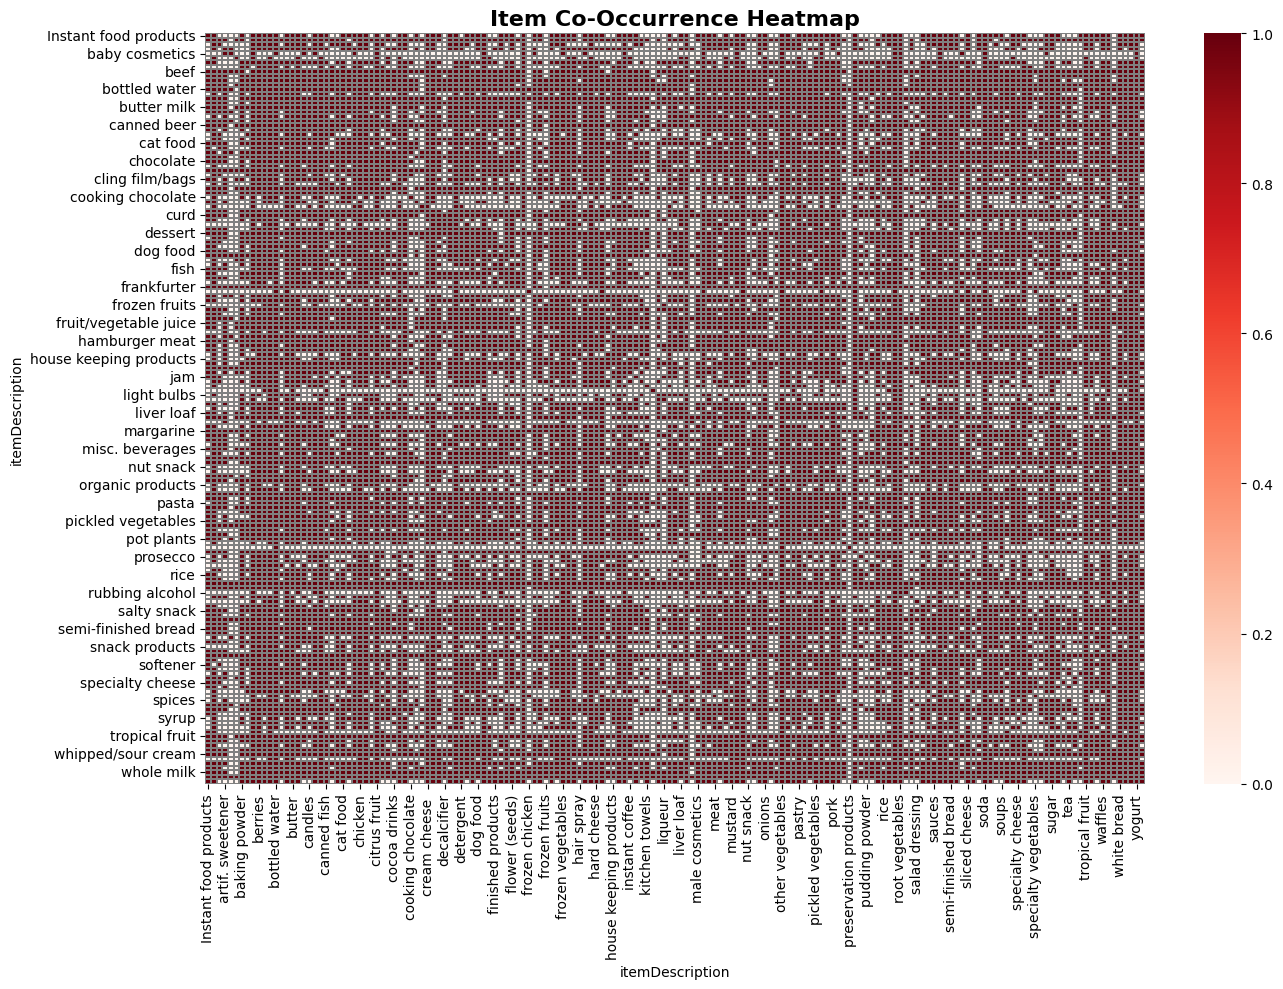

In [22]:
# Compute co-occurrence matrix from your one-hot encoded DataFrame
co_occurrence = basket_sets.T.dot(basket_sets)

plt.figure(figsize=(14,10))
sns.heatmap(
    co_occurrence,
    cmap='Reds',
    linewidths=0.1,
    linecolor='grey'
)

plt.title('Item Co-Occurrence Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()

plt.savefig("M:\TOSS\WEEK 1\Week 1 kagle Example\Heatmap")
plt.show()


This heatmap displays how often pairs of items appear together in the same transaction. Darker shades indicate stronger co‑occurrence. Items like whole milk, yogurt, bottled water, and root vegetables show frequent pairings, reinforcing their importance in rule generation. The heatmap also reveals subtle relationships not captured by association rules, offering broader insights into customer behaviour.

## 📊 Visualisation Summary
- The visualisations in this analysis provide a multi‑layered understanding of customer purchasing behaviour:

- The Top 20 Most Frequent Items chart confirms that products like whole milk, other vegetables, and rolls/buns are staple purchases, forming the backbone of many transactions.

- The Support vs Confidence Scatter Plot shows that most rules are moderately frequent but consistently reliable, validating the chosen thresholds of 7% support and 50% confidence.

- The Lift Distribution Histogram reveals that while most rules have modest lift values (1.10–1.18), they still represent meaningful associations beyond random chance.

- The Association Rule Network Graph highlights whole milk as a central anchor item, frequently linked to other products such as yogurt, pastry, and bottled water, making it a strategic target for cross‑selling.

- The Item Co‑Occurrence Heatmap uncovers broader relationships between items, including subtle pairings not captured by association rules, offering deeper insights into basket composition.

- Together, these visualisations reinforce the strength and interpretability of the rules generated, and provide actionable insights for product placement, bundling strategies, and promotional targeting.

## 🛒 Strategic Recommendations Based on Market Basket Insights
- he findings from the association rules, item frequencies, and co‑occurrence patterns point to several practical strategies that retailers can implement to enhance sales, improve customer experience, and optimise store layout.

- 1. Strengthen Cross‑Selling Around Anchor Products
Items like whole milk, other vegetables, and rolls/buns act as anchor products in many baskets. Their strong connections to items such as yogurt, pastry, bottled water, and domestic eggs suggest opportunities to:

Place complementary items nearby

Create bundle promotions (e.g., “Buy whole milk, get yogurt 10% off”)

Use end‑caps to highlight high‑frequency pairings

This leverages natural customer behaviour to increase basket size.

- 2. Optimise Store Layout Using Co‑Occurrence Patterns
The heatmap reveals broader item relationships beyond the strongest rules. Retailers can use these patterns to:

Position frequently co‑purchased items in adjacent aisles

Reduce customer search time, improving satisfaction

Encourage impulse purchases by grouping related categories

For example, root vegetables, tropical fruit, and yogurt show strong co‑occurrence and could form a “fresh essentials” zone.

- 3. Target Promotions at High‑Frequency, High‑Lift Items
Lift values above 1 indicate meaningful associations. Even though most lifts are modest, they still highlight reliable pairings. Retailers can:

Offer targeted discounts on items with strong lift

Use loyalty card data to personalise offers

Promote items that frequently appear with staples to increase exposure

This ensures promotions align with real purchasing behaviour.

- 4. Improve Inventory Planning for Core Products
High‑frequency items such as whole milk, other vegetables, and rolls/buns require consistent stock availability. Retailers should:

Prioritise replenishment cycles for these items

Monitor demand fluctuations closely

Use association patterns to anticipate spikes (e.g., milk + eggs + pastry before weekends)

This reduces stockouts and maintains customer trust.

- 5. Design Themed Marketing Campaigns
The network graph highlights natural product clusters. These can inspire themed campaigns such as:

“Breakfast Essentials” (milk, eggs, pastry, yogurt)

“Weekend Shopping” (beer, sausage, rolls/buns)

“Healthy Basket” (other vegetables, tropical fruit, bottled water)

These campaigns resonate because they reflect real customer habits.

- 6. Enhance Online Recommendation Systems
For online retailers, association rules can directly power:

“Frequently bought together” suggestions

Dynamic product recommendations

Personalised shopping lists

This improves user experience and increases average order value.

## 🏁 Conclusion
- This Market Basket Analysis explored customer purchasing behaviour using a dataset of 38,765 transactions and 167 unique products. After transforming the data into a basket format, frequent itemsets were generated using the FP‑Growth algorithm with a minimum support threshold of 7%, resulting in 83 meaningful itemsets. FP‑Growth proved more efficient than Apriori for this dataset, producing the same results with significantly better performance.

- Association rules were then derived from these itemsets using a minimum confidence threshold of 50%, ensuring that only reliable and consistent co‑purchase patterns were retained. Several strong rules emerged, particularly involving high‑frequency items such as whole milk, yogurt, and other vegetables. These rules highlight clear relationships in customer behaviour and provide a foundation for practical applications such as product placement, cross‑selling strategies, and targeted promotions.

- Overall, the combination of a 7% support threshold and 50% confidence threshold produced a balanced and interpretable set of insights, offering a clear understanding of the most influential purchasing patterns within the dataset